# Import thư viện

In [1]:
!pip install split-folders
import splitfolders
# !pip install tensorflow
# !pip install --upgrade keras

In [2]:
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
dataset_dir = "/kaggle/input/rice-leaf-disease-image"
class_names = os.listdir(dataset_dir)  # Danh sách các class trong dataset
class_names

['Tungro', 'Bacterialblight', 'Blast', 'Brownspot']

## Overview

Class: Tungro, Number of images: 1308
Class: Bacterialblight, Number of images: 1584
Class: Blast, Number of images: 1440
Class: Brownspot, Number of images: 1600
Total Images: 5932


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


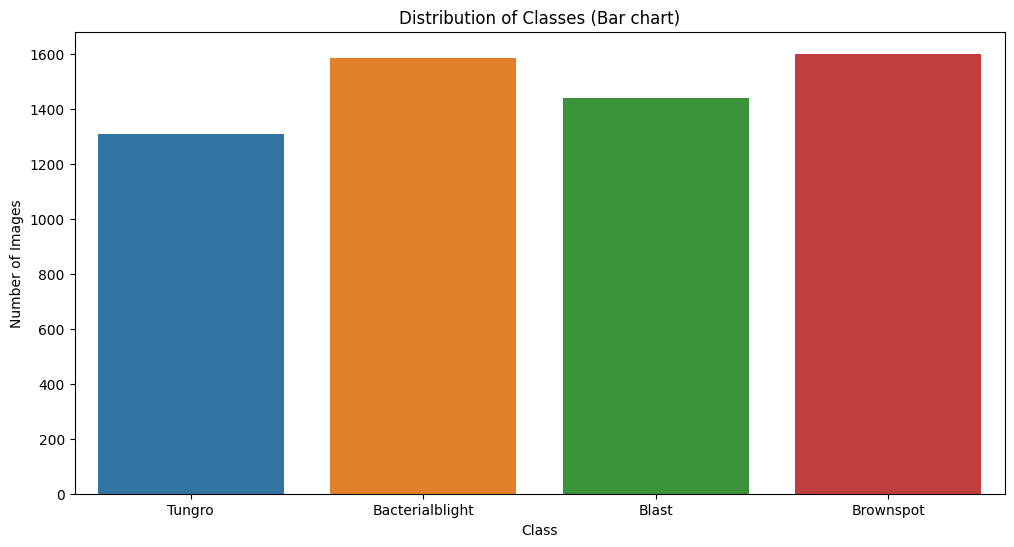

In [4]:
class_count = []

# Đếm số lượng ảnh trong từng class
for class_ in class_names:
    class_path = os.path.join(dataset_dir, class_)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_}, Number of images: {num_images}")
    
    class_count.append(num_images)
    
# Tính tổng số lượng ảnh trong toàn bộ dataset
total_images = sum(len(os.listdir(os.path.join(dataset_dir, class_))) for class_ in class_names)
print(f"Total Images: {total_images}")

plt.figure(figsize = (12,6))
sns.barplot(x = class_names, y = class_count)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Classes (Bar chart)")

plt.show()

## Display Images

In [5]:
def display_images(dataset_dir, class_name, n = 5):
    class_path = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_path)[:n] #lấy 10 ảnh đầu tiên
    plt.figure(figsize = (20,10))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # do OpenCV đọc ảnh dưới dạng RGB
        plt.subplot(1, 5, i + 1) # 1 hàng, 5 cột
        plt.imshow(img)
        plt.title(image_file)
#         plt.axis("off")
    plt.show()   

### Bacterial Blight - Bạc lá

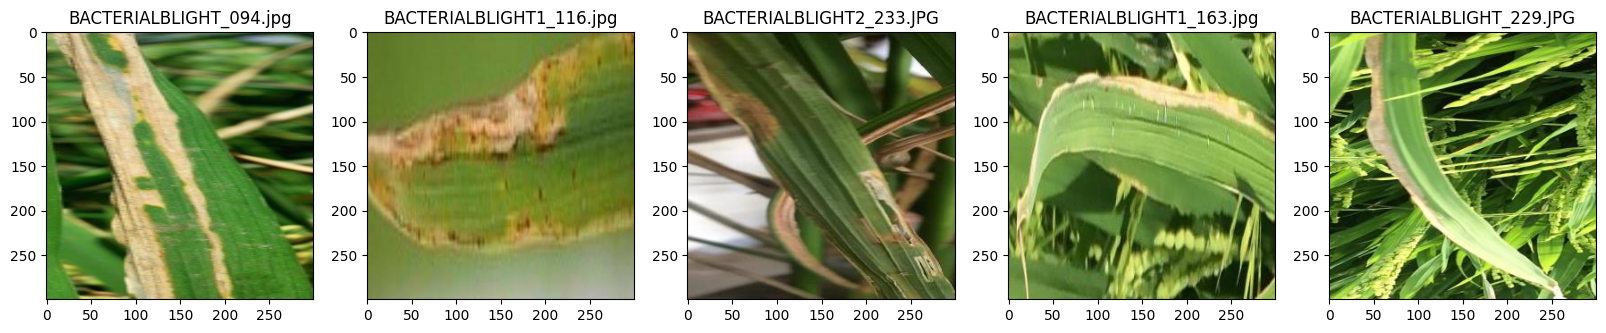

In [6]:
class_name = "Bacterialblight"
display_images(dataset_dir, class_name)

### Blast - Nấm đạo ôn

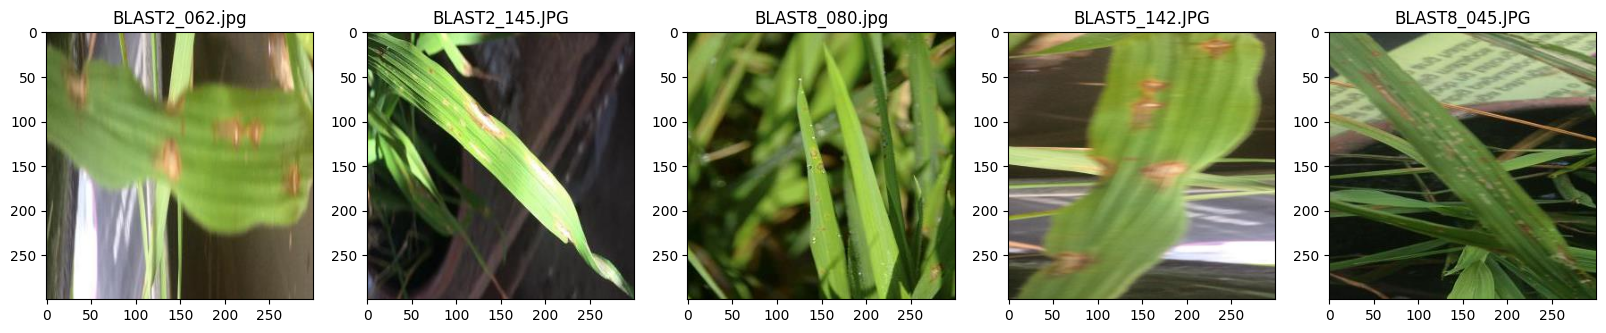

In [7]:
class_name = "Blast"
display_images(dataset_dir, class_name)

### Brown spot - Đốm nâu

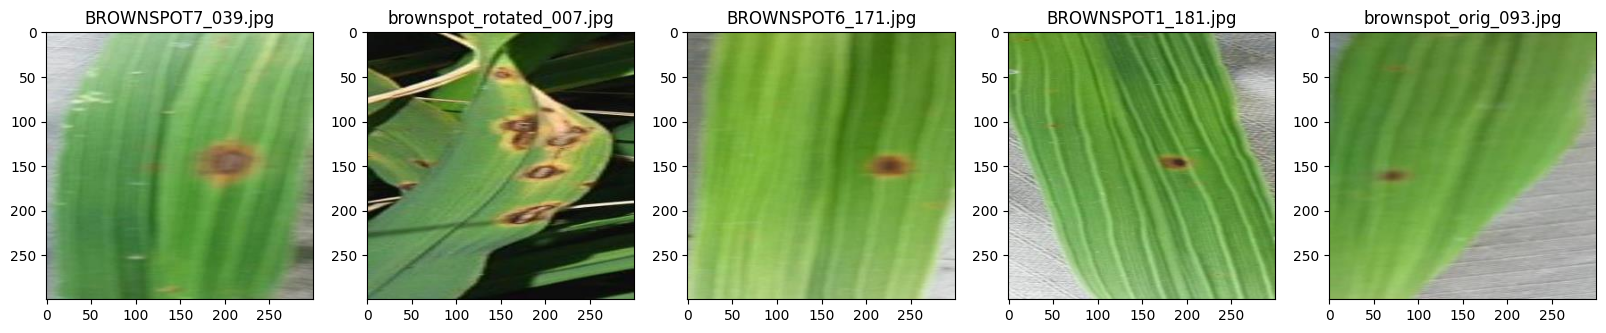

In [8]:
class_name = "Brownspot"
display_images(dataset_dir, class_name)

### Tungro

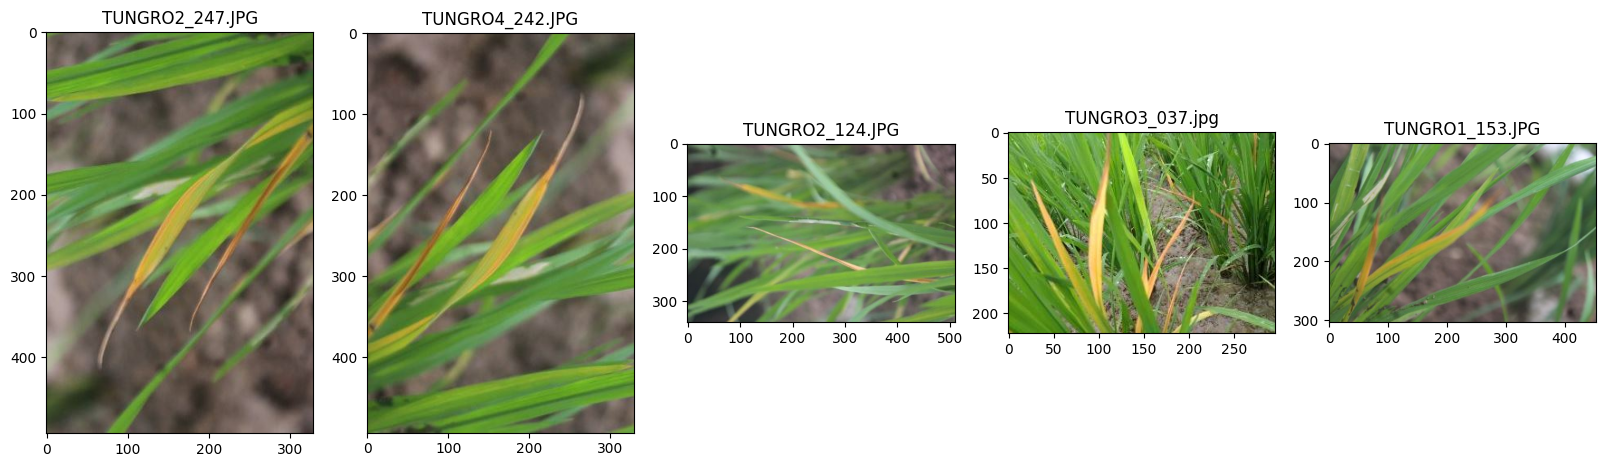

In [9]:
class_name = "Tungro"
display_images(dataset_dir, class_name)

## Chia tập dữ liệu

In [10]:
dataset_dir = "/kaggle/input/rice-leaf-disease-image"

splitfolders.ratio(dataset_dir, output = '4 Diseases Images',
                  seed=42, ratio=(.80, .10, .10), #train 80, valid 10, test 10
#                   move = False
                  )

Copying files: 5932 files [00:43, 137.93 files/s]


In [12]:
train_path = '/kaggle/working/4 Diseases Images/train'
val_path = '/kaggle/working/4 Diseases Images/val'
test_path = '/kaggle/working/4 Diseases Images/test'

In [13]:
BATCH_SIZE = 32
SIZE = 299
n_epochs = 100

In [27]:
BATCH_SIZE = 32
SIZE = 224
n_epochs = 100

In [28]:
train_ImageGen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    zoom_range=0.2
                                    )

vt_ImageGen = ImageDataGenerator(rescale = 1./255)

In [29]:
train_images = train_ImageGen.flow_from_directory(train_path,
                                           target_size = (SIZE,SIZE),
                                           batch_size = BATCH_SIZE,
                                           class_mode = "categorical",
                                           )
val_images = vt_ImageGen.flow_from_directory(val_path,
                                           target_size = (SIZE,SIZE),
                                           batch_size = BATCH_SIZE,
                                           class_mode = "categorical"
                                           )
test_images = vt_ImageGen.flow_from_directory(test_path,
                                           target_size = (SIZE,SIZE),
                                           batch_size = BATCH_SIZE,
                                           class_mode = "categorical",
                                           shuffle = False
                                           )

Found 4745 images belonging to 4 classes.
Found 592 images belonging to 4 classes.
Found 595 images belonging to 4 classes.


In [55]:
# # Count images in each class for train set
# print("\nNumber of images in each class (Train set):")
# for class_name, class_index in train_images.class_indices.items():
#     count = np.sum(train_images.classes == class_index)
#     print(f"{class_name}: {count}")

# # Count images in each class for validation set
# print("\nNumber of images in each class (Validation set):")
# for class_name, class_index in val_images.class_indices.items():
#     count = np.sum(val_images.classes == class_index)
#     print(f"{class_name}: {count}")

# # Count images in each class for test set
# print("\nNumber of images in each class (Test set):")
# for class_name, class_index in test_images.class_indices.items():
#     count = np.sum(test_images.classes == class_index)
#     print(f"{class_name}: {count}")


Number of images in each class (Train set):
Bacterialblight: 1267
Blast: 1152
Brownspot: 1280
Tungro: 1046

Number of images in each class (Validation set):
Bacterialblight: 158
Blast: 144
Brownspot: 160
Tungro: 130

Number of images in each class (Test set):
Bacterialblight: 159
Blast: 144
Brownspot: 160
Tungro: 132


## BUILD MODEL

### 1.InceptionV3

In [16]:
def build_model_incv3():
    model = InceptionV3(include_top = False, weights = "imagenet", input_shape = (SIZE,SIZE,3))
    
    #Freeze các params của Pretrain Model
    for layer in model.layers:
        layer.trainable = False    
        
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout để giảm overfitting
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)  # Dropout để giảm overfitting
    outputs = Dense(4, activation = "softmax")(x) #4 classes
    model = Model(inputs = model.input, outputs = outputs)
    return model

In [17]:
model_1 = build_model_incv3()
model_1.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy', 
              metrics = ["accuracy"])
# model_1.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
#With Earlystop only
callbacks = [
    EarlyStopping(patience = 10, monitor = 'val_loss', restore_best_weights = True, verbose=1),
    ModelCheckpoint(filepath='incv3_model.keras', save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)  
]

history = model_1.fit(train_images,validation_data = val_images, epochs = n_epochs,
                      callbacks = callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 134s 732ms/step - accuracy: 0.6002 - loss: 0.9574 - val_accuracy: 0.8750 - val_loss: 0.3260
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 575ms/step - accuracy: 0.8472 - loss: 0.4003 - val_accuracy: 0.9240 - val_loss: 0.1994
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 575ms/step - accuracy: 0.8969 - loss: 0.2967 - val_accuracy: 0.9375 - val_loss: 0.1751
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 580ms/step - accuracy: 0.8884 - loss: 0.2880 - val_accuracy: 0.9443 - val_loss: 0.1417
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 577ms/step - accuracy: 0.9096 - loss: 0.2611 - val_accuracy: 0.9578 - val_loss: 0.1227
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 577ms/step - accuracy: 0.9183 - loss: 0.2344 - val_accuracy: 0.9662 - val_loss: 0.1107
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 576ms/step - accuracy: 0.9167 - loss: 0.2232 - val_accuracy: 0.9679 - val_loss: 0.0973
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 572ms/step - accuracy: 0.9311 - loss: 0.18

### Đánh giá mô hình

149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 601ms/step - accuracy: 0.9907 - loss: 0.0275
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9944 - loss: 0.0160
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 790ms/step - accuracy: 0.9972 - loss: 0.0289


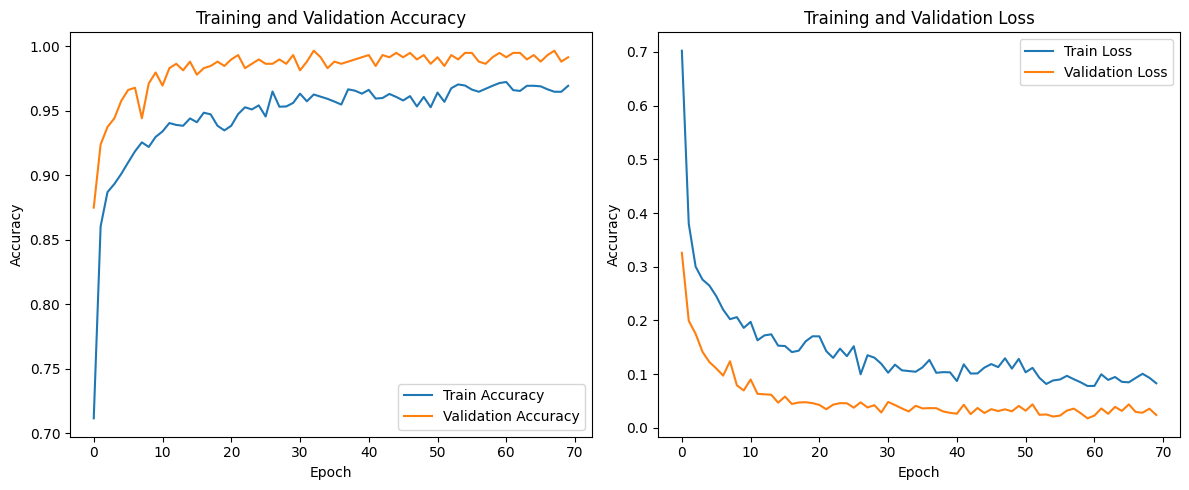

In [19]:
model_1.evaluate(train_images)
model_1.evaluate(val_images)
model_1.evaluate(test_images)

plt.figure(figsize=(12, 5))  

# summarize history for accuracy
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 
# summarize history for loss
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các đồ thị
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 450ms/step


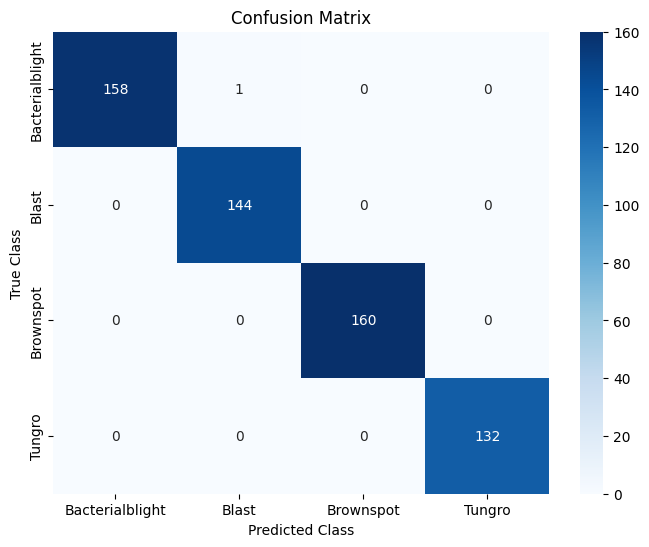

                 precision    recall  f1-score   support

Bacterialblight       1.00      0.99      1.00       159
          Blast       0.99      1.00      1.00       144
      Brownspot       1.00      1.00      1.00       160
         Tungro       1.00      1.00      1.00       132

       accuracy                           1.00       595
      macro avg       1.00      1.00      1.00       595
   weighted avg       1.00      1.00      1.00       595



In [20]:
predictions = model_1.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_classes = test_images.classes  # True classes
class_names = list(test_images.class_indices.keys())  # Class names

cm = confusion_matrix(true_classes,predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)


In [21]:
model_1 = load_model('/kaggle/working/incv3_model.keras')

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step


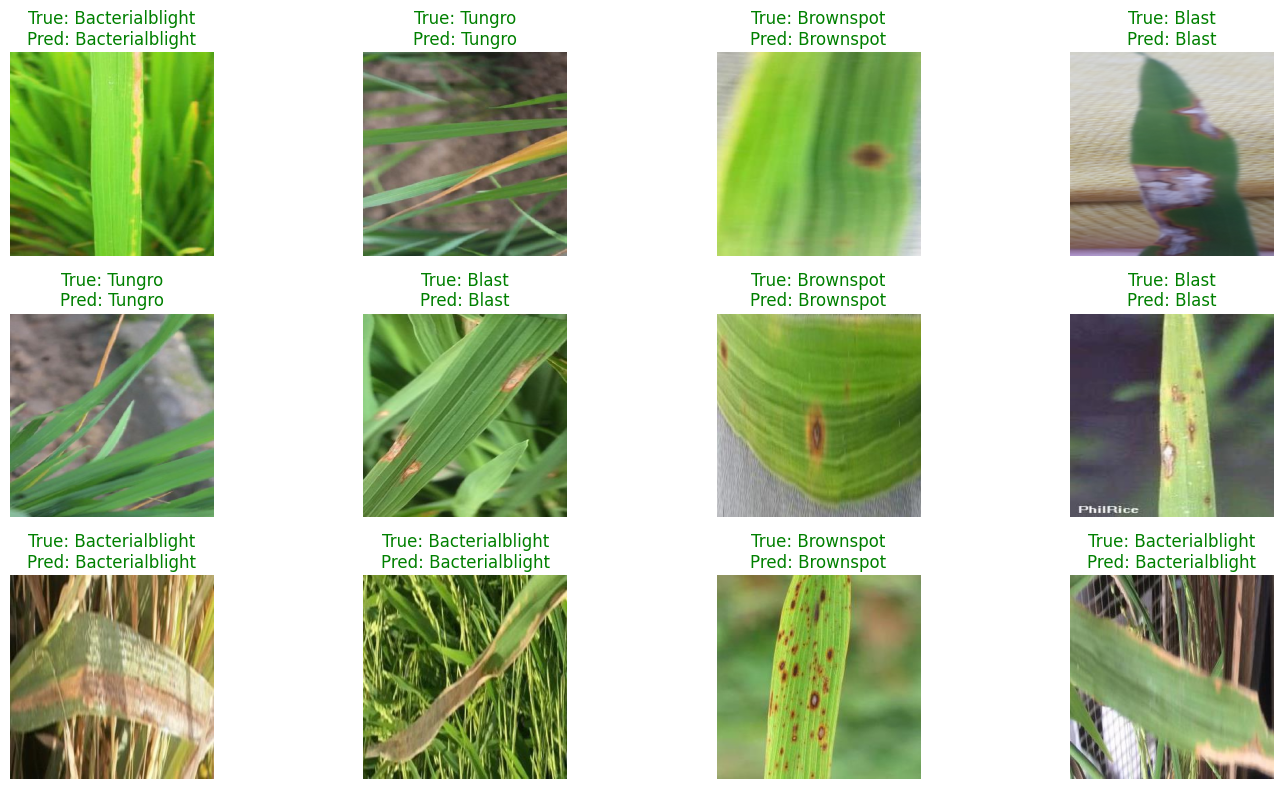

In [91]:
import random

def get_test_images(generator):
    images = []
    labels = []
    for _ in range(len(generator)):
        batch_images, batch_labels = next(generator)
        images.extend(batch_images)
        labels.extend(batch_labels)
    return np.array(images), np.array(labels)

images, labels = get_test_images(test_images)
predictions = model_1.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)
class_labels = list(test_images.class_indices.keys())

random_indices = random.sample(range(len(images)), 12) #random indices from the entire test set


plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    color = 'green' if predicted_classes[idx] == true_classes[idx] else 'red'
    plt.subplot(3, 4, i+1)
    plt.imshow(images[idx])
    plt.title(f"True: {class_labels[true_classes[idx]]}\nPred: {class_labels[predicted_classes[idx]]}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


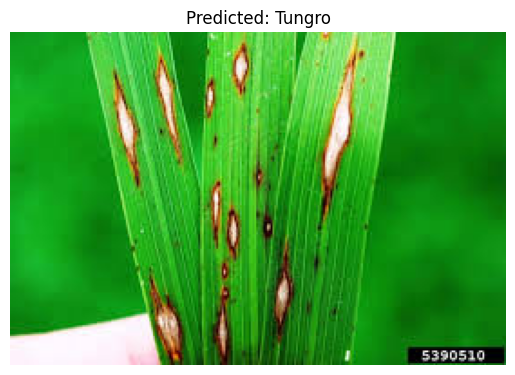

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

# Đường dẫn đến ảnh
img_path = '/kaggle/input/vidutest/images_.jpg'

# Tải và tiền xử lý ảnh
def preprocess_image(img_path, target_size):
    # Mở ảnh và thay đổi kích thước
    img = Image.open(img_path).convert("RGB").resize(target_size)
    
    # Chuyển ảnh thành array
    img_array = np.array(img)
    
    # Chuẩn hóa về [0, 1]
    img_array = img_array / 255.0
    
    # Thêm chiều batch (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Đọc ảnh và tiền xử lý (thay (224, 224) bằng kích thước đầu vào của mô hình)
input_image = preprocess_image(img_path, target_size=(299,299))

# Dự đoán
predictions = model_1.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Hiển thị kết quả
class_names = ['Bacterialblight', 'Blast',  'Brownspot', 'Tungro']  
plt.imshow(Image.open(img_path))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

### ResNet50

In [ ]:
def build_model_resnet50():
    model = ResNet50(include_top=False, weights='imagenet', input_shape = (SIZE,SIZE,3))
    
    #Freeze các params của Pretrain Model
    for layer in model.layers:
        layer.trainable = False  
        
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)  
    model = Model(inputs=model.input, outputs=outputs, name="model_use_ResNet50")
    
    return model

model_2 = build_model_resnet50()
model_2.compile(optimizer = Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics = ["accuracy"])
# model_2.summary()

#With Earlystop only
callbacks = [
    EarlyStopping(patience = 5, monitor = 'val_loss', restore_best_weights = True, verbose=1),
    ModelCheckpoint(filepath='rn50_model.keras', save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)  
]

history = model_2.fit(train_images,validation_data = val_images, epochs = 10, 
                      callbacks = callbacks
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 72s 391ms/step - accuracy: 0.2639 - loss: 1.6474 - val_accuracy: 0.2669 - val_loss: 1.3586
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 51s 329ms/step - accuracy: 0.2666 - loss: 1.5462 - val_accuracy: 0.4628 - val_loss: 1.3378
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 50s 323ms/step - accuracy: 0.2895 - loss: 1.4642 - val_accuracy: 0.4527 - val_loss: 1.3189
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 51s 323ms/step - accuracy: 0.2988 - loss: 1.4286 - val_accuracy: 0.4426 - val_loss: 1.3032
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 51s 325ms/step - accuracy: 0.3287 - loss: 1.3861 - val_accuracy: 0.4628 - val_loss: 1.2903
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 51s 325ms/step - accuracy: 0.3358 - loss: 1.3716 - val_accuracy: 0.4730 - val_loss: 1.2768
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 51s 326ms/step - accuracy: 0.3615 - loss: 1.3412 - val_accuracy: 0.4443 - val_loss: 1.2650
Epoch 8/10
105/149 ━━━━━━━━━━━━━━━━━━━━ 14s 322ms/step - accuracy: 0.3834 - loss: 1.3130

In [ ]:
model_2.evaluate(train_ds)
model_2.evaluate(test_ds)
model_2.evaluate(val_ds)

plt.figure(figsize=(12, 5))  
# summarize history for accuracy

plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 
# summarize history for loss
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các đồ thị
plt.show()

In [ ]:
predictions = model_2.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_classes = test_images.classes  # True classes
class_names = list(test_images.class_indices.keys())  # Class names

cm = confusion_matrix(true_classes,predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)
